In [1]:
import numpy as np
import os
import pandas as pd
import datetime
from os.path import isfile, join

from random import *

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.dates as mdat
import matplotlib.mlab as mlab

import sklearn.preprocessing

import seaborn as sns
import missingno as msno

from keras import backend as K
from keras import utils, models, layers, optimizers
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from sklearn import metrics
import tensorflow as tf



Using TensorFlow backend.


#### Resources to guide feature engineering exploration: 
- https://code.kx.com/q/wp/space-weather/
- FDL PCA and feature engineering analyses


In [2]:
# Function to find nearest indice in array (works with datetimes)
def nearest(items, pivot):
    #return min(items, key=lambda x: abs(x - pivot))
    return np.argmin(abs(items - pivot))



### Read in and prepare data

Data can be obtained from [Google Drive Data Folder and the following file: ML_DB_2010.csv](https://drive.google.com/drive/u/0/folders/1k57deom9D_Me0zR061ZzfUJdQTTbAanl)

In [3]:
# Read in DMSP data and reduce to F-16 data
file_2010 = '/Users/ryanmcgranaghan/Documents/DMSPdata/ML_DB_2010.csv'
df = pd.read_csv(file_2010)

In [4]:
# Clean up the columns and redefine the datetime as the index
df.index = pd.DatetimeIndex( df['Unnamed: 0'] )
df.index.names = ['Datetimes']
df.drop(['Unnamed: 0','key_0'], axis=1, inplace=True)

cols_pt_one = [col for col in df.columns if '.1' in col]
print(cols_pt_one)
df.drop(cols_pt_one, axis=1, inplace=True)

['Bz_1min.1', 'By_1min.1', 'Bx_1min.1', 'AE_1min.1', 'SymH_1min.1', 'vsw_1min.1', 'psw_1min.1', 'borovsky_1min.1', 'newell_1min.1']


In [5]:
# Data are stacked by satellite (e.g., F16 for all of 2010 then F17 for all of 2010, etc.).
#  So, one can isolate the three satellite's data by identifying the final datetime in 2010.
#  We apply this here to isolate the F16 data as a minimal data set to work with.
idxs_2010 = np.where( df.index == '2010-12-30 23:59:00'  )

print('idxs signaling the end of 2010:\n idx for end of F16 data = {}\n idx for end of F17 data = {}\n idx for end of F18 data = {}'.format(
                                                                              idxs_2010[0][0],
                                                                              idxs_2010[0][1],
                                                                              idxs_2010[0][2]))

# Isolate F-16 data
df = df[idxs_2010[0][0]:idxs_2010[0][1]]
print('shape of F-16 data = {}'.format(df.shape))

idxs signaling the end of 2010:
 idx for end of F16 data = 524159
 idx for end of F17 data = 1049759
 idx for end of F18 data = 1575359
shape of F-16 data = (525600, 91)


In [6]:
# Sin and Cos values were incorrectly calculated and stored in ML_DB_xxxx.csv files. 
#  Recalculating those values for UT and LT (RMM 3.21.2019)
ut = []
for d in range(len(df)):
    dt_now = ( df.index[d] )
    ut.append( (dt_now - dt_now.replace(hour=0, minute=0, second=0, microsecond=0)).total_seconds() )
    
df['sin_ut'] = [np.sin(2*np.pi*(x/60.)/1440.) for x in ut]
df['cos_ut'] = [np.cos(2*np.pi*(x/60.)/1440.) for x in ut]

df['sin_SC_AACGM_LTIME'] = [np.sin(2*np.pi*x/24.) for x in df['SC_AACGM_LTIME'].values]
df['cos_SC_AACGM_LTIME'] = [np.cos(2*np.pi*x/24.) for x in df['SC_AACGM_LTIME'].values]


In [7]:
df.describe()

,SC_AACGM_LAT,SC_AACGM_LTIME,ELE_TOTAL_ENERGY_FLUX,ELE_AVG_ENERGY,sin_ut,cos_ut,sin_doy,cos_doy,sin_SC_AACGM_LTIME,cos_SC_AACGM_LTIME,...,newell_1min,Bz_5min,By_5min,Bx_5min,AE_5min,SymH_5min,vsw_5min,psw_5min,borovsky_5min,newell_5min
count,137428.000000,137428.000000,1.374280e+05,137428.000000,5.256000e+05,5.256000e+05,137428.000000,137428.000000,137428.000000,137428.000000,...,5.256000e+05,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,5.256000e+05,5.256000e+05
mean,64.889660,11.515179,4.171846e+10,613.065319,3.460787e-18,-5.018140e-17,0.002065,0.025948,0.046943,-0.380442,...,9.169807e+06,433.529888,433.104932,433.775415,113.742485,-8.635550,7918.402104,1.626510,1.742269e+15,9.169807e+06
std,11.837300,4.580857,9.161521e+11,1222.921020,7.071075e-01,7.071075e-01,0.712939,0.700748,0.867665,0.316583,...,4.253653e+07,2036.210239,2036.301414,2036.158123,150.438240,11.919619,26304.533185,1.072698,8.804350e+15,4.253653e+07
min,45.000081,4.827802,1.977965e+06,33.464790,-1.000000e+00,-1.000000e+00,-0.999991,-0.999963,-1.000000,-1.000000,...,0.000000e+00,-16.270000,-21.060000,-11.790000,2.000000,-89.000000,259.700000,0.090000,0.000000e+00,0.000000e+00
25%,54.581638,6.772570,2.055273e+08,71.001761,-7.071068e-01,-7.071068e-01,-0.723644,-0.658402,-0.901769,-0.595947,...,7.249217e+02,-1.330000,-2.310000,-1.610000,30.000000,-14.000000,341.000000,0.990000,7.859576e+03,7.249217e+02
50%,65.511082,11.530883,5.464392e+08,146.978814,6.123234e-17,-6.123234e-17,0.008607,0.038722,0.122506,-0.342633,...,2.346267e+03,0.270000,-0.290000,0.800000,54.000000,-7.000000,389.500000,1.340000,1.881989e+04,2.346331e+03
75%,74.996051,16.292769,2.106430e+10,449.528372,7.071068e-01,7.071068e-01,0.723644,0.726608,0.975757,-0.149201,...,4.895603e+03,1.930000,2.280000,2.740000,135.000000,-2.000000,476.200000,1.940000,3.536640e+04,4.895603e+03
max,88.563840,18.499241,2.477821e+14,15620.000559,1.000000e+00,1.000000e+00,0.999991,1.000000,1.000000,0.302087,...,2.095289e+08,9999.990000,9999.990000,9999.990000,2328.000000,57.000000,99999.900000,32.760000,8.000337e+16,2.095289e+08


In [8]:
df.columns.to_list()

['SC_AACGM_LAT',
 'SC_AACGM_LTIME',
 'ELE_TOTAL_ENERGY_FLUX',
 'ELE_AVG_ENERGY',
 'sin_ut',
 'cos_ut',
 'sin_doy',
 'cos_doy',
 'sin_SC_AACGM_LTIME',
 'cos_SC_AACGM_LTIME',
 'Bz',
 'By',
 'Bx',
 'AE',
 'SymH',
 'vsw',
 'psw',
 'borovsky',
 'newell',
 'Bz_6hr',
 'By_6hr',
 'Bx_6hr',
 'AE_6hr',
 'SymH_6hr',
 'vsw_6hr',
 'psw_6hr',
 'borovsky_6hr',
 'newell_6hr',
 'Bz_5hr',
 'By_5hr',
 'Bx_5hr',
 'AE_5hr',
 'SymH_5hr',
 'vsw_5hr',
 'psw_5hr',
 'borovsky_5hr',
 'newell_5hr',
 'Bz_3hr',
 'By_3hr',
 'Bx_3hr',
 'AE_3hr',
 'SymH_3hr',
 'vsw_3hr',
 'psw_3hr',
 'borovsky_3hr',
 'newell_3hr',
 'Bz_1hr',
 'By_1hr',
 'Bx_1hr',
 'AE_1hr',
 'SymH_1hr',
 'vsw_1hr',
 'psw_1hr',
 'borovsky_1hr',
 'newell_1hr',
 'Bz_4min',
 'By_4min',
 'Bx_4min',
 'AE_4min',
 'SymH_4min',
 'vsw_4min',
 'psw_4min',
 'borovsky_4min',
 'newell_4min',
 'Bz_3min',
 'By_3min',
 'Bx_3min',
 'AE_3min',
 'SymH_3min',
 'vsw_3min',
 'psw_3min',
 'borovsky_3min',
 'newell_3min',
 'Bz_1min',
 'By_1min',
 'Bx_1min',
 'AE_1min',
 'SymH

### Plot data

- Useful reference: https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html#visualization-scatter

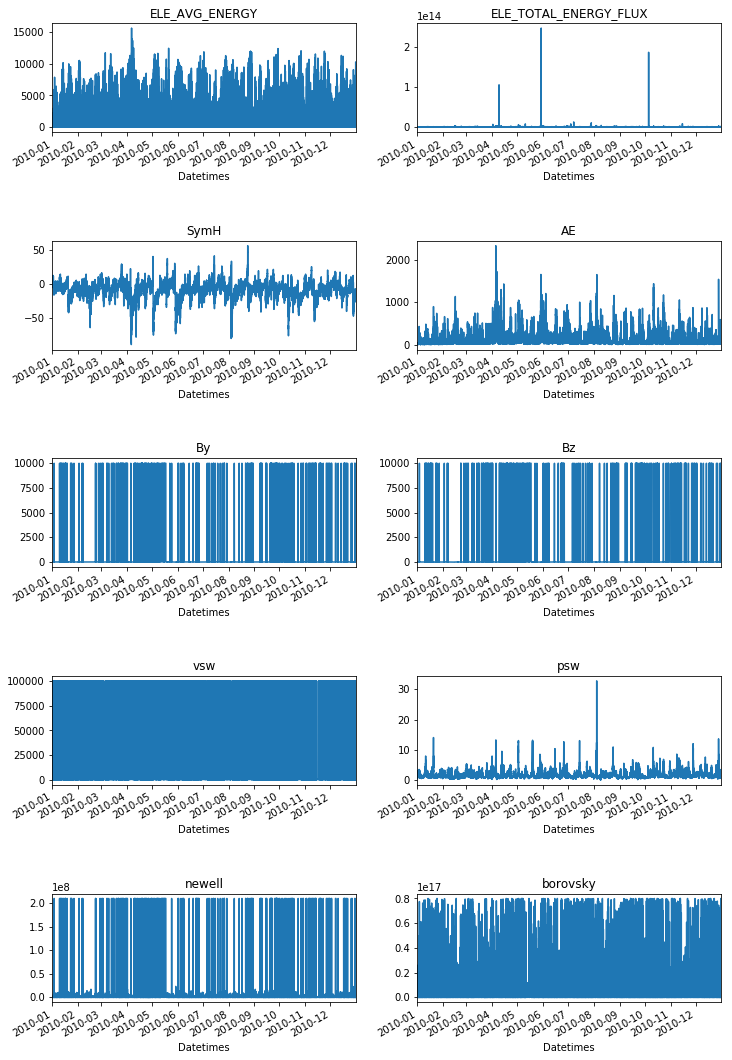

In [9]:
# df.plot(subplots=True, layout=(-1,3), figsize=(12, 20), sharex=True)
# df.plot(subplots=True, layout=(-1,2), sharex=True)

# gcf().autofmt_xdate() 

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12,20))
df['ELE_AVG_ENERGY'].plot(ax=axes[0, 0]);
axes[0, 0].set_title('ELE_AVG_ENERGY');
df['ELE_TOTAL_ENERGY_FLUX'].plot(ax=axes[0, 1]);
axes[0, 1].set_title('ELE_TOTAL_ENERGY_FLUX');

df['SymH'].plot(ax=axes[1, 0]);
axes[1, 0].set_title('SymH');
df['AE'].plot(ax=axes[1, 1]);
axes[1, 1].set_title('AE');

df['By'].plot(ax=axes[2, 0]);
axes[2, 0].set_title('By');
df['Bz'].plot(ax=axes[2, 1]);
axes[2, 1].set_title('Bz');

df['vsw'].plot(ax=axes[3, 0]);
axes[3, 0].set_title('vsw');
df['psw'].plot(ax=axes[3, 1]);
axes[3, 1].set_title('psw');

df['newell'].plot(ax=axes[4, 0]);
axes[4, 0].set_title('newell');
df['borovsky'].plot(ax=axes[4, 1]);
axes[4, 1].set_title('borovsky');

plt.subplots_adjust(hspace=1)



### Generate polar plot observation density

In [10]:
latres = 2.0
ltres = 1
mlats = np.arange(45,90,latres)
mlts = np.arange(0,24,ltres)
# mlts = np.append(mlts,[0])

xgrid, ygrid = np.meshgrid(mlts,mlats)

# print(xgrid)

# print(ygrid)

grid_density = np.zeros_like(xgrid)
for i in range(len(mlats)):
    for j in range(len(mlts)):
        if (j == 0):
#             print('current rule:  \n   MLAT: {}-{} \n   MLT: {}-{}'.format(mlats[i]-(latres/2.),
#                                                                            mlats[i]+(latres/2.),
#                                                                            0,
#                                                                            mlts[j]+(ltres/2.)))
            grid_density[i,j] = ( df[ (df['SC_AACGM_LAT']>=(mlats[i]-(latres/2.))) &
                                      (df['SC_AACGM_LAT']<(mlats[i]+(latres/2.)))  & 
                                      (df['SC_AACGM_LTIME']>(0.)) &
                                      (df['SC_AACGM_LTIME']<(mlts[j]+(ltres/2.)))
                                    ].count()[0] )
        elif (j == len(mlts)-1):
#             print('current rule:  \n   MLAT: {}-{} \n   MLT: {}-{}'.format(mlats[i]-(latres/2.),
#                                                                            mlats[i]+(latres/2.),
#                                                                            23.5,
#                                                                            24))
            grid_density[i,j] = ( df[ (df['SC_AACGM_LAT']>=(mlats[i]-(latres/2.))) &
                                      (df['SC_AACGM_LAT']<(mlats[i]+(latres/2.)))  & 
                                      (df['SC_AACGM_LTIME']>=(23.5)) 
                                    ].count()[0] )
        else: 
#             print('current rule:  \n   MLAT: {}-{} \n   MLT: {}-{}'.format(mlats[i]-(latres/2.),
#                                                                            mlats[i]+(latres/2.),
#                                                                            mlts[j]-(ltres/2.),
#                                                                            mlts[j]+(ltres/2.)))
            grid_density[i,j] = ( df[ (df['SC_AACGM_LAT']>=(mlats[i]-(latres/2.))) &
                                      (df['SC_AACGM_LAT']<(mlats[i]+(latres/2.)))  & 
                                      (df['SC_AACGM_LTIME']>=(mlts[j]-(ltres/2.))) &
                                      (df['SC_AACGM_LTIME']<(mlts[j]+(ltres/2.)))
                                    ].count()[0] )
        
# print(grid_density)


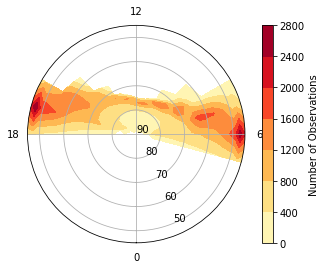

In [11]:
# Plot the grid density

# Redefine zero grid points to NaN so that they do not show up on the plot
grid_density = grid_density.astype('float')
grid_density[grid_density == 0.] = np.nan

# This simply transforms the mlt, mlat, x- and y-grid values into form needed for polar plot 
#     (i.e., colatitude and theta radians)
mlats_plot = (mlats - 90.)*-1.
mlts_plot = mlts * 15. * (np.pi/180.)
ygrid_plot = (ygrid - 90.)*-1. 
xgrid_plot = (xgrid*15.) * (np.pi/180.)


# Create polar plot
ax = plt.subplot(111, polar=True)
ctf = ax.contourf(mlts_plot, mlats_plot, grid_density, cmap='YlOrRd')
# ctf = ax.contourf(xgrid_plot, ygrid_plot, grid_density, cmap='YlOrRd')
cbar = plt.colorbar(ctf)
cbar.ax.set_ylabel('Number of Observations')

# define your axis limits
ax.set_ylim([0,45])

# Set the radius labels
ax.set_yticks(np.arange(0,50,10))  # less radial ticks
ax.set_yticklabels(90 - np.arange(0,50,10))  # less radial ticks

# Set the circumference labels
ax.set_xticks(np.linspace(0, 2*np.pi, 4, endpoint=False))
ax.set_xticklabels(('0','6','12','18'))      
# Make the labels go clockwise
# ax.set_theta_direction(-1)

ax.grid(True)
ax.set_theta_zero_location("S")

plt.show()

### Identify missing data values



##### TO DO: Address issue in existing database in which previous solar wind data averages were calculated using missing data points, which are  in-filled by OMNI Web by unrealistic values (e.g., 9999.99). These cause issues in the data that are currently removed (below) by setting a threshole for the magnitude of the solar wind variables and removing data outside of those thresholds. 

Potential future solution: 
1. Remove existing previous data
2. Remove outliers of current solar wind data
3. Data in-fill (simple forward/background filling)
4. Re-calculate previous solar wind data

Another potential solution is to fix 'time_hist2.py' to explicitly remove filled values from calculations and re-generate DMSP ML databases

Currently, we set a threshold and set data that exceed it to NaN. This is a relatively robust solution to excluding effects from missing solar wind data points

In [12]:
# Just a quick check
col_name = 'Bz_6hr'
col_thresh = 500.

chc = np.argwhere(df[col_name][ df[col_name] > col_thresh ])
print('number of {} data points exceeding {} = {}'.format(col_name,col_thresh,len(chc)))
print('length of the dataframe = {}'.format(len(df)))

number of Bz_6hr data points exceeding 500.0 = 37875
length of the dataframe = 525600


/anaconda3/envs/python36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)


In [13]:
def outlier_detect_and_replace(df,str_id,outlier_value):
    """This function takes a dataframe, finds any columns 
    matching 'str_id' in the provided dataframe, and replaces
    all values that exceed the 'outlier_value' with NaN"""
    print('working on {} outlier detection and removal'.format(str_id))
    print('outlier value = {}'.format(outlier_value))

    cols = [ col for col in df.columns if str_id in col]
    print('will detect and replace for columns = {}'.format(cols))
    for i in cols:
        df[i][ df[i] > outlier_value ] = np.NaN

    return df

In [14]:
df_updated = df.copy(deep=True)

   # NOTE: Require lower thresholds than outlier value in OMNIWeb database due to 
   #   calculation of previous time values (e.g., Bz_6hr) resulting in values unrealistically 
   # large, but less than OMNIWeb threshold 
    
   # TO DO: Perform previous times calculate AFTER correcting for outlier solar wind values 
   #   --> SOLUTION: fill outliers with NaNs, THEN calculate previous times
   #   --> SOLUTION: can calculate those here and repopulate the dataframe for previous time values    

# IMF_outlier = 1000. #9999.99
IMF_outlier = 200. #9999.99
str_id = 'B'
df_updated = outlier_detect_and_replace(df_updated,str_id,IMF_outlier)

print('--------------------------------------------------------------')

# vsw_outlier = 10000. #99999.9
vsw_outlier = 2000. #99999.9
str_id = 'vsw'
df_updated = outlier_detect_and_replace(df_updated,str_id,vsw_outlier)

print('--------------------------------------------------------------')

# borovsky_outlier = 1e6 #df['borovsky'].quantile(.90)
borovsky_outlier = 1e5 #df['borovsky'].quantile(.90)
str_id = 'borovsky'
df_updated = outlier_detect_and_replace(df_updated,str_id,borovsky_outlier)

print('--------------------------------------------------------------')

# newell_outlier = 1e5 #df['newell'].quantile(.90)
newell_outlier = 9e3 #df['newell'].quantile(.90)
str_id = 'newell'
df_updated = outlier_detect_and_replace(df_updated,str_id,newell_outlier)

working on B outlier detection and removal
outlier value = 200.0
will detect and replace for columns = ['Bz', 'By', 'Bx', 'Bz_6hr', 'By_6hr', 'Bx_6hr', 'Bz_5hr', 'By_5hr', 'Bx_5hr', 'Bz_3hr', 'By_3hr', 'Bx_3hr', 'Bz_1hr', 'By_1hr', 'Bx_1hr', 'Bz_4min', 'By_4min', 'Bx_4min', 'Bz_3min', 'By_3min', 'Bx_3min', 'Bz_1min', 'By_1min', 'Bx_1min', 'Bz_5min', 'By_5min', 'Bx_5min']
--------------------------------------------------------------
working on vsw outlier detection and removal
outlier value = 2000.0
will detect and replace for columns = ['vsw', 'vsw_6hr', 'vsw_5hr', 'vsw_3hr', 'vsw_1hr', 'vsw_4min', 'vsw_3min', 'vsw_1min', 'vsw_5min']
--------------------------------------------------------------
working on borovsky outlier detection and removal
outlier value = 100000.0
will detect and replace for columns = ['borovsky', 'borovsky_6hr', 'borovsky_5hr', 'borovsky_3hr', 'borovsky_1hr', 'borovsky_4min', 'borovsky_3min', 'borovsky_1min', 'borovsky_5min']
------------------------------------

In [15]:
print('number of points where Bz = 9999.99: {}'.format(len(np.argwhere(df['Bz'].values == 9999.99))))
print('number of points where Bz updated = 9999.99: {}'.format(len(np.argwhere(df_updated['Bz'].values == 9999.99))))

print('\nnumber of points where Bz updated = NaN: {}'.format(len(np.argwhere( np.isnan(df_updated['Bz'].values) ))))


number of points where Bz = 9999.99: 22780
number of points where Bz updated = 9999.99: 0

number of points where Bz updated = NaN: 22780


In [16]:
thresh_chc = 1000.
print('number of points where Bz_6hr > {}: {}'.format(thresh_chc,len(np.argwhere(df['Bz_6hr'].values > thresh_chc))))
print('number of points where Bz_6hr updated > {}: {}'.format(thresh_chc,len(np.argwhere(df_updated['Bz_6hr'].values > thresh_chc))))

thresh_chc = 200.
print('number of points where Bz_6hr > {}: {}'.format(thresh_chc,len(np.argwhere(df['Bz_6hr'].values > thresh_chc))))
print('number of points where Bz_6hr updated > {}: {}'.format(thresh_chc,len(np.argwhere(df_updated['Bz_6hr'].values > thresh_chc))))



number of points where Bz_6hr > 1000.0: 30755
number of points where Bz_6hr updated > 1000.0: 0
number of points where Bz_6hr > 200.0: 37875
number of points where Bz_6hr updated > 200.0: 0


/anaconda3/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys


### Plot data

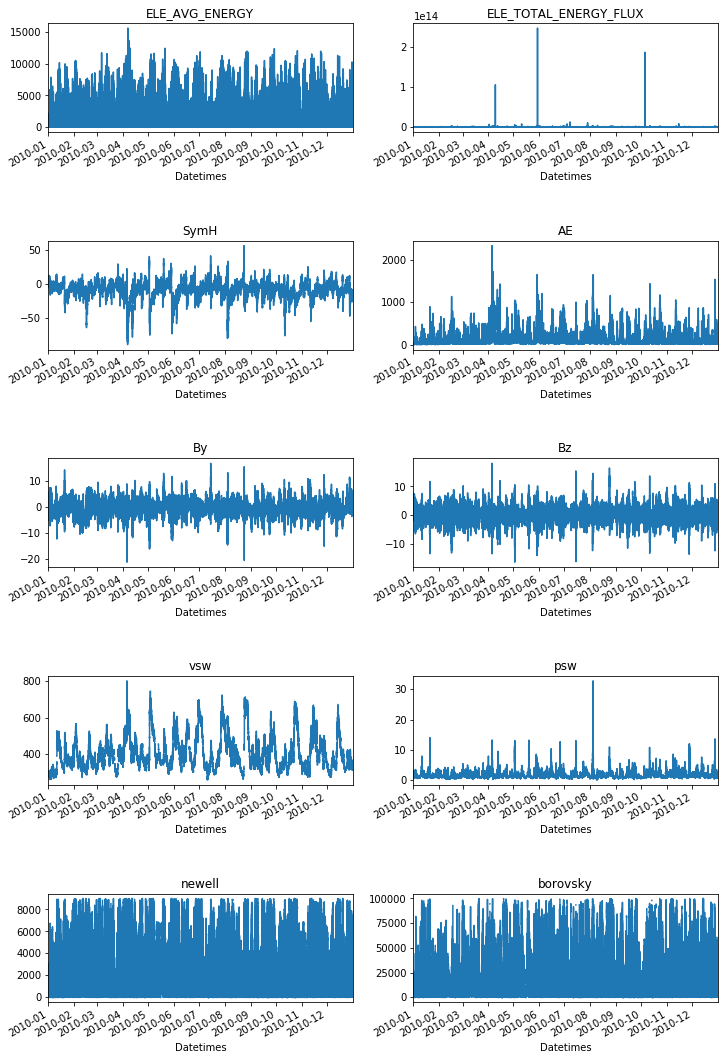

In [17]:
# df_updated.plot(subplots=True, layout=(-1,3), figsize=(12, 20), sharex=True)
# df_updated.plot(subplots=True, layout=(-1,2), sharex=True)

# gcf().autofmt_xdate() 

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12,20))
df_updated['ELE_AVG_ENERGY'].plot(ax=axes[0, 0]);
axes[0, 0].set_title('ELE_AVG_ENERGY');
df_updated['ELE_TOTAL_ENERGY_FLUX'].plot(ax=axes[0, 1]);
axes[0, 1].set_title('ELE_TOTAL_ENERGY_FLUX');

df_updated['SymH'].plot(ax=axes[1, 0]);
axes[1, 0].set_title('SymH');
df_updated['AE'].plot(ax=axes[1, 1]);
axes[1, 1].set_title('AE');

df_updated['By'].plot(ax=axes[2, 0]);
axes[2, 0].set_title('By');
df_updated['Bz'].plot(ax=axes[2, 1]);
axes[2, 1].set_title('Bz');

df_updated['vsw'].plot(ax=axes[3, 0]);
axes[3, 0].set_title('vsw');
df_updated['psw'].plot(ax=axes[3, 1]);
axes[3, 1].set_title('psw');

df_updated['newell'].plot(ax=axes[4, 0]);
axes[4, 0].set_title('newell');
df_updated['borovsky'].plot(ax=axes[4, 1]);
axes[4, 1].set_title('borovsky');

plt.subplots_adjust(hspace=1)



Plotting averages from the previous six hour time point!




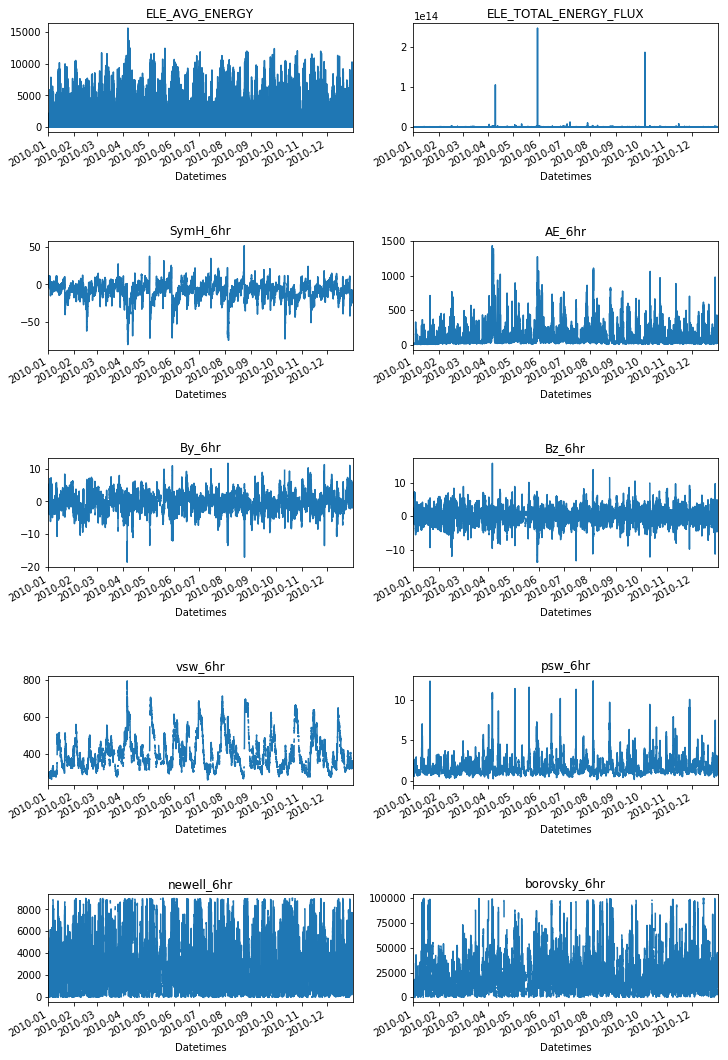

In [18]:
# df_updated.plot(subplots=True, layout=(-1,3), figsize=(12, 20), sharex=True)
# df_updated.plot(subplots=True, layout=(-1,2), sharex=True)

# gcf().autofmt_xdate() 

print('Plotting averages from the previous six hour time point!\n\n')


fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12,20))
df_updated['ELE_AVG_ENERGY'].plot(ax=axes[0, 0]);
axes[0, 0].set_title('ELE_AVG_ENERGY');
df_updated['ELE_TOTAL_ENERGY_FLUX'].plot(ax=axes[0, 1]);
axes[0, 1].set_title('ELE_TOTAL_ENERGY_FLUX');

df_updated['SymH_6hr'].plot(ax=axes[1, 0]);
axes[1, 0].set_title('SymH_6hr');
df_updated['AE_6hr'].plot(ax=axes[1, 1]);
axes[1, 1].set_title('AE_6hr');

df_updated['By_6hr'].plot(ax=axes[2, 0]);
axes[2, 0].set_title('By_6hr');
df_updated['Bz_6hr'].plot(ax=axes[2, 1]);
axes[2, 1].set_title('Bz_6hr');

df_updated['vsw_6hr'].plot(ax=axes[3, 0]);
axes[3, 0].set_title('vsw_6hr');
df_updated['psw_6hr'].plot(ax=axes[3, 1]);
axes[3, 1].set_title('psw_6hr');

df_updated['newell_6hr'].plot(ax=axes[4, 0]);
axes[4, 0].set_title('newell_6hr');
df_updated['borovsky_6hr'].plot(ax=axes[4, 1]);
axes[4, 1].set_title('borovsky_6hr');

plt.subplots_adjust(hspace=1)






# # Make sure previous solar wind values are realistic
# # df_updated['Bz_6hr'].plot();
# # df_updated['vsw_6hr'].plot();
# # df_updated['borovsky_6hr'].plot();
# df_updated['newell_6hr'].plot();

### Look at the distributions of the updated data

It is critical to understand the distributions of each variable. Here we provide summary statistics and basic histograms for the data. Set num_vars_loop to determine how many of the variables the for loop will run through


---------------------------------------------------------------
---------------------------------------------------------------

VARIABLE = SC_AACGM_LAT
   mean         = 64.88965957202792
   max          = 88.56384030136982
   min          = 45.000081323410654
   80th %ile    = 76.19271544165785
   # NaNs       = 388172


/anaconda3/envs/python36/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/envs/python36/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


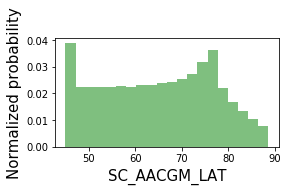


---------------------------------------------------------------
---------------------------------------------------------------

VARIABLE = SC_AACGM_LTIME
   mean         = 11.515179070242064
   max          = 18.499240888146684
   min          = 4.8278022356994015
   80th %ile    = 16.537228190169735
   # NaNs       = 388172


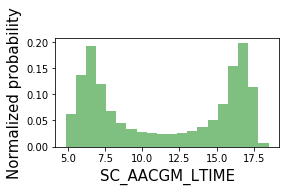


---------------------------------------------------------------
---------------------------------------------------------------

VARIABLE = ELE_TOTAL_ENERGY_FLUX
   mean         = 41718458900.13183
   max          = 247782145488402.25
   min          = 1977964.833333333
   80th %ile    = 37988612602.66667
   # NaNs       = 388172


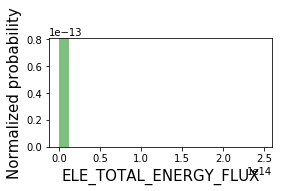


---------------------------------------------------------------
---------------------------------------------------------------

VARIABLE = ELE_AVG_ENERGY
   mean         = 613.0653187284108
   max          = 15620.000559322041
   min          = 33.46479
   80th %ile    = 685.276811310001
   # NaNs       = 388172


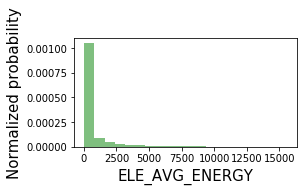


---------------------------------------------------------------
---------------------------------------------------------------

VARIABLE = sin_ut
   mean         = 3.4607865364266674e-18
   max          = 1.0
   min          = -1.0
   80th %ile    = 0.8090169943749475
   # NaNs       = 0


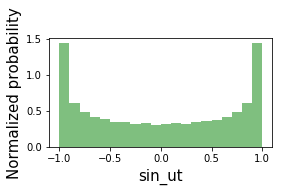


---------------------------------------------------------------
---------------------------------------------------------------

VARIABLE = cos_ut
   mean         = -5.018140477818668e-17
   max          = 1.0
   min          = -1.0
   80th %ile    = 0.8090169943749475
   # NaNs       = 0


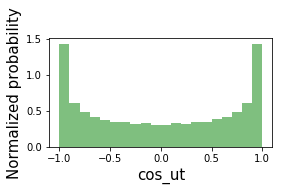


---------------------------------------------------------------
---------------------------------------------------------------

VARIABLE = sin_doy
   mean         = 0.0020650337397398084
   max          = 0.99999073973619
   min          = -0.99999073973619
   80th %ile    = 0.8214765533024142
   # NaNs       = 388172


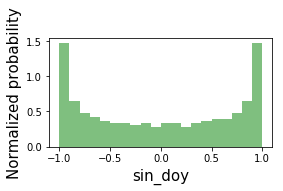


---------------------------------------------------------------
---------------------------------------------------------------

VARIABLE = cos_doy
   mean         = 0.02594770185014717
   max          = 1.0
   min          = -0.9999629591162656
   80th %ile    = 0.8239230057575536
   # NaNs       = 388172


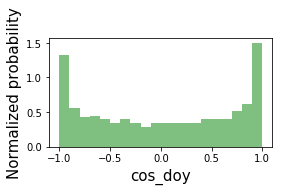


---------------------------------------------------------------
---------------------------------------------------------------

VARIABLE = sin_SC_AACGM_LTIME
   mean         = 0.04694282007791444
   max          = 0.9999999996633835
   min          = -0.9999999974896085
   80th %ile    = 0.9856011917821301
   # NaNs       = 388172


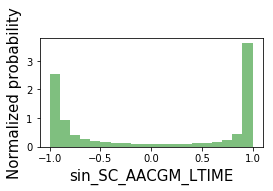


---------------------------------------------------------------
---------------------------------------------------------------

VARIABLE = cos_SC_AACGM_LTIME
   mean         = -0.3804421170943417
   max          = 0.30208650212117594
   min          = -0.9999999999028929
   80th %ile    = -0.10827182331207275
   # NaNs       = 388172


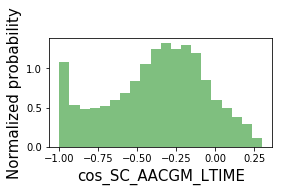


---------------------------------------------------------------
---------------------------------------------------------------

VARIABLE = Bz
   mean         = 0.12635353605664054
   max          = 18.05
   min          = -16.27
   80th %ile    = 2.08
   # NaNs       = 22780


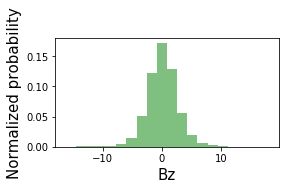


---------------------------------------------------------------
---------------------------------------------------------------

VARIABLE = By
   mean         = -0.3178450538960263
   max          = 16.94
   min          = -21.06
   80th %ile    = 2.45
   # NaNs       = 22780


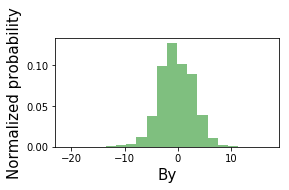


---------------------------------------------------------------
---------------------------------------------------------------

VARIABLE = Bx
   mean         = 0.3829851636768625
   max          = 10.87
   min          = -11.79
   80th %ile    = 2.8500000000000005
   # NaNs       = 22780


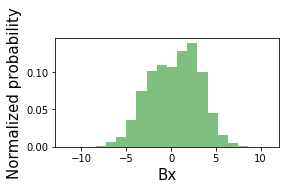


---------------------------------------------------------------
---------------------------------------------------------------

VARIABLE = AE
   mean         = 113.74283675799087
   max          = 2328.0
   min          = 2.0
   80th %ile    = 170.0
   # NaNs       = 0


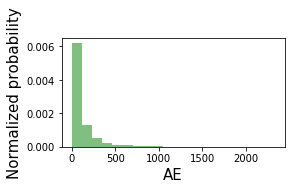


---------------------------------------------------------------
---------------------------------------------------------------

VARIABLE = SymH
   mean         = -8.635721080669711
   max          = 57.0
   min          = -89.0
   80th %ile    = 0.0
   # NaNs       = 0


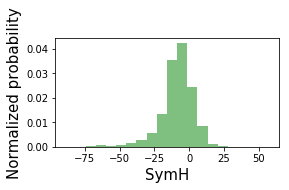


---------------------------------------------------------------
---------------------------------------------------------------

VARIABLE = vsw
   mean         = 404.1953481911347
   max          = 802.6
   min          = 259.7
   80th %ile    = 471.1
   # NaNs       = 39660


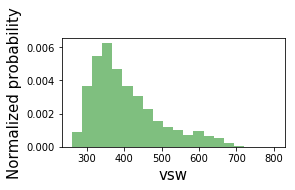


---------------------------------------------------------------
---------------------------------------------------------------

VARIABLE = psw
   mean         = 1.6265124619482503
   max          = 32.76
   min          = 0.09
   80th %ile    = 2.13
   # NaNs       = 0


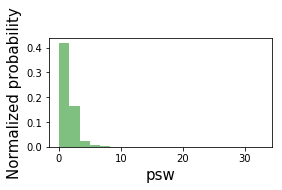


---------------------------------------------------------------
---------------------------------------------------------------

VARIABLE = borovsky
   mean         = 20782.29928766514
   max          = 99999.00036391633
   min          = 0.0
   80th %ile    = 33435.41462330729
   # NaNs       = 46325


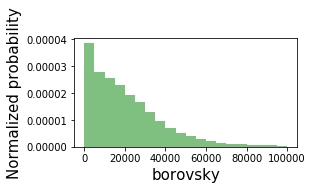


---------------------------------------------------------------
---------------------------------------------------------------

VARIABLE = newell
   mean         = 2459.0445676859904
   max          = 8999.213027026983
   min          = 0.0
   80th %ile    = 4339.627983219353
   # NaNs       = 59500


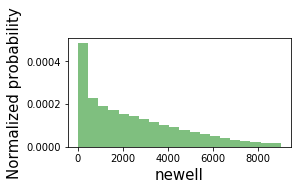


---------------------------------------------------------------
---------------------------------------------------------------

VARIABLE = Bz_6hr
   mean         = 0.12493705705847791
   max          = 15.930769230769226
   min          = -13.798461538461538
   80th %ile    = 1.7663076923077012
   # NaNs       = 37875


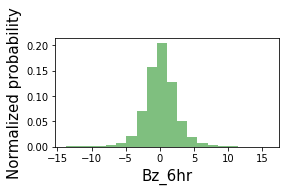


---------------------------------------------------------------
---------------------------------------------------------------

VARIABLE = By_6hr
   mean         = -0.3218141134072244
   max          = 11.61153846153846
   min          = -18.471538461538465
   80th %ile    = 2.2876923076923075
   # NaNs       = 37875


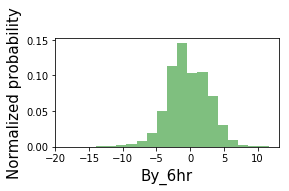


---------------------------------------------------------------
---------------------------------------------------------------

VARIABLE = Bx_6hr
   mean         = 0.3872605779581023
   max          = 9.507692307692308
   min          = -10.315384615384612
   80th %ile    = 2.7
   # NaNs       = 37875


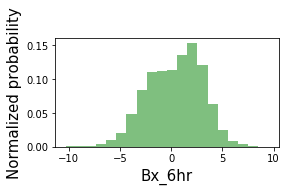


---------------------------------------------------------------
---------------------------------------------------------------

VARIABLE = AE_6hr
   mean         = 113.69037363891817
   max          = 1437.6153846153845
   min          = 2.9230769230769234
   80th %ile    = 170.15384615384616
   # NaNs       = 0


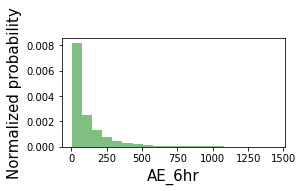


---------------------------------------------------------------
---------------------------------------------------------------

VARIABLE = SymH_6hr
   mean         = -8.625133912890762
   max          = 51.846153846153854
   min          = -80.30769230769229
   80th %ile    = -0.15384615384615385
   # NaNs       = 0


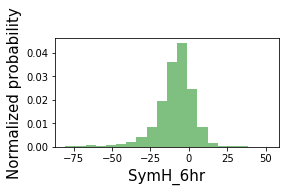


---------------------------------------------------------------
---------------------------------------------------------------

VARIABLE = vsw_6hr
   mean         = 408.09092478263386
   max          = 793.3
   min          = 261.53846153846155
   80th %ile    = 476.2153846153846
   # NaNs       = 148135


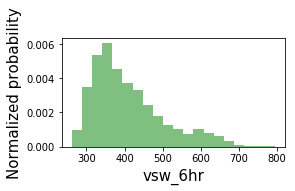


---------------------------------------------------------------
---------------------------------------------------------------

VARIABLE = psw_6hr
   mean         = 1.6278412375781666
   max          = 12.37076923076923
   min          = 0.10692307692307693
   80th %ile    = 2.135
   # NaNs       = 0


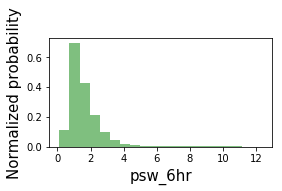


---------------------------------------------------------------
---------------------------------------------------------------

VARIABLE = borovsky_6hr
   mean         = 21447.958763936324
   max          = 99903.66242299082
   min          = 19.619498781748952
   80th %ile    = 32382.39591136652
   # NaNs       = 156975


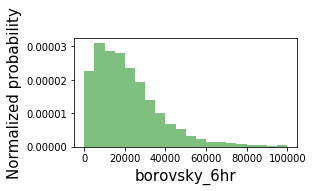


---------------------------------------------------------------
---------------------------------------------------------------

VARIABLE = newell_6hr
   mean         = 2675.8762274511423
   max          = 8996.518722503937
   min          = 0.5570683494547628
   80th %ile    = 4437.562836171007
   # NaNs       = 149665


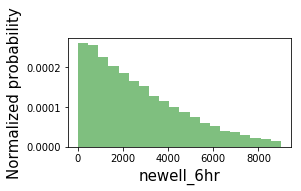


---------------------------------------------------------------
---------------------------------------------------------------

VARIABLE = Bz_5hr
   mean         = 0.1250751613653659
   max          = 15.930769230769226
   min          = -13.798461538461538
   80th %ile    = 1.7663076923077012
   # NaNs       = 37875


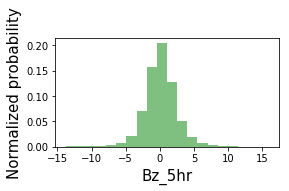

In [19]:
num_bins = 20
num_vars_loop = 30

ctr = 0
for i in df_updated.columns:
    ctr += 1
    if ctr == num_vars_loop:
        break
    print('')    
    print('---------------------------------------------------------------')
    print('---------------------------------------------------------------')
    print('')
    print('VARIABLE = {}'.format(i))
    print('   mean         = {}'.format(df_updated[i].mean()))
    print('   max          = {}'.format(df_updated[i].max()))
    print('   min          = {}'.format(df_updated[i].min()))
    print('   80th %ile    = {}'.format(df_updated[i].quantile(.80)))
    print('   # NaNs       = {}'.format(len ( np.argwhere( np.isnan(df_updated[i].values) ) )))


    fig = plt.figure()
    fig.set_size_inches(4,2)
    plt.hist(df_updated[i], num_bins, density=1, facecolor='green', alpha=0.5)
    plt.xlabel(i, fontsize=15)#, labelpad=-30)
    plt.ylabel('Normalized probability', fontsize=15)#, labelpad=-30)
    plt.show()


### To Do: 
1. Remove unwanted 'feature' columns - *DONE*
2. Remove NaNs from the database - *DONE*
3. Examine pdfs to determine which features should be treated logarithmically - *DONE*
4. Define a predictive task and prepare the predicted variable accordingly - *DONE*
5. Define ML pipeline (to prevent 'data leakage' and other common data preparation and evaluation errors)  
    a. Scale the features  
    b. Assign ML estimators (SVM, DTs; NNs need be treated separately(?))  
    
    
    ***Currently accomplishing this manually, but 'pipelines' will be required for more effective collaborative work (see, e.g., [scikit learn pipelines](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)***
    


In [20]:
working_DataFrame_label = 'df_updated'
print('Declaration of the details of the current working DataFrame to initialize \n  the ML preparation process and corresponding details: \n')
print('     DataFrame: {} \n'.format(working_DataFrame_label))
print('     Details: \n')
print('          Outliers have been removed and replaced by NaNs\n')
print('          No treatment of predicted variable has been applied\n')
print('          Both features and predicted variables included in {}\n'.format(working_DataFrame_label))
print('          Unwanted features still included in {}\n'.format(working_DataFrame_label))
print('          Data < 55 degrees still included in {}\n'.format(working_DataFrame_label))




Declaration of the details of the current working DataFrame to initialize 
  the ML preparation process and corresponding details: 

     DataFrame: df_updated 

     Details: 

          Outliers have been removed and replaced by NaNs

          No treatment of predicted variable has been applied

          Both features and predicted variables included in df_updated

          Unwanted features still included in df_updated

          Data < 55 degrees still included in df_updated



In [21]:
# Split the data into features and predicted variables
feature_cols = [c for c in df_updated.columns if not 'ELE' in c]
df_ML = df_updated.copy(deep=True).fillna(method='bfill').fillna(method='ffill')
df_updated_features_only = df_ML[feature_cols].copy(deep=True)
df_updated_avgE = df_ML['ELE_AVG_ENERGY'].copy(deep=True)
df_updated_totEflux = df_ML['ELE_TOTAL_ENERGY_FLUX'].copy(deep=True)


##### ACCOMPLISH THE PRE-PROCESSING MANUALLY


##### Split the data into train, test, and validation

In [22]:
# Define the dataframe indices
indices = df_ML.index

# Split the data into train, test, and validation OR use cross validation
# use the first X data points as testing data
num_test = 5000
num_val = 5000
test_indices = [0,num_test]
train_indices = [num_test+1,len(df_ML)-num_val]
val_indices = [len(df_ML)-num_val+1,len(df_ML)]

print('range of testing data: {}-{}, length: {}'.format(0,
                                                        num_test,
                                                        num_test-0))
print('range of training data: {}-{}, length: {}'.format(num_test+1,
                                                         len(df_ML)-num_val, 
                                                         (len(df_ML)-num_val) - (num_test+1) ))
print('range of validation data: {}-{}, length: {}'.format(len(df_ML)-num_val+1,
                                                           len(df_ML), 
                                                           len(df_ML) - (len(df_ML)-num_val+1) ))

X = df_updated_features_only
y = df_updated_avgE

X_train = X[train_indices[0]:train_indices[1]]
X_test = X[test_indices[0]:test_indices[1]]
X_val = X[val_indices[0]:val_indices[1]]

y_train = y[train_indices[0]:train_indices[1]]
y_test = y[test_indices[0]:test_indices[1]]
y_val = y[val_indices[0]:val_indices[1]]

indices_train = indices[train_indices[0]:train_indices[1]]
indices_test = indices[test_indices[0]:test_indices[1]]
indices_val = indices[val_indices[0]:val_indices[1]]

range of testing data: 0-5000, length: 5000
range of training data: 5001-520600, length: 515599
range of validation data: 520601-525600, length: 4999


##### Transform the training data for ML


In [23]:
from sklearn.preprocessing import StandardScaler

# Create log scaler
log_scaler_func = sklearn.preprocessing.FunctionTransformer(np.log,inverse_func=np.exp)
features_to_log_scale = [col for col in df_updated_features_only.columns if ('psw' in col) or ('newell' in col) or ('borovsky' in col) or ('AE' in col)]
features_to_only_standard_scale = [col for col in df_updated_features_only.columns if col not in features_to_log_scale]


# Pull aside the columns that will only be standard scaled
X_train_not_scaled = X_train.copy()[features_to_only_standard_scale]

# Log scale the selected features to log scale
log_scaler_func = sklearn.preprocessing.FunctionTransformer(np.log)#,inverse_func=np.exp)
log_transformer_manual = log_scaler_func.fit(X_train.copy()[features_to_log_scale])
X_train_log_scaled_manual = pd.DataFrame(log_transformer_manual.transform(X_train.copy()[features_to_log_scale]), columns=features_to_log_scale,index=indices_train)

X_train_transformed_manual = pd.concat([X_train_not_scaled,X_train_log_scaled_manual],axis=1)

# Fill in the INFs and NaNs
X_train_transformed_manual[ (np.isinf(X_train_transformed_manual)) | (np.isnan(X_train_transformed_manual)) ] = 0.
# X_train_transformed_manual = X_train_transformed_manual.fillna(method='bfill').fillna(method='ffill')

# Finally, standard scale the whole dataframe
standard_transformer_manual = StandardScaler()
matrix_full_scaled_manual = standard_transformer_manual.fit_transform(X_train_transformed_manual.values)
X_train_full_scaled_manual = pd.DataFrame(matrix_full_scaled_manual,
                                        index=X_train_transformed_manual.index,
                                        columns=X_train_transformed_manual.columns)

print('about to train the SVR model')

from sklearn.svm import SVR

# Optionally sub-select the total training data to increase model training time
training_data_pts = 50000
print('using only {} of the training data samples'.format(training_data_pts))


clf = SVR(kernel='rbf', gamma='scale', C=1.0, epsilon=0.2, verbose = 1)
clf.fit(X_train_full_scaled_manual[0:training_data_pts], y_train[0:training_data_pts])




/anaconda3/envs/python36/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/anaconda3/envs/python36/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/anaconda3/envs/python36/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:201: RuntimeWarning: divide by zero encountered in log
  **(kw_args if kw_args else {}))


about to train the SVR model
using only 50000 of the training data samples
[LibSVM]

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.2, gamma='scale',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=1)

##### Transform the test data for prediction (same process applied to testing data)

In [24]:
# Pull aside the columns that will only be standard scaled
X_test_not_scaled = X_test.copy()[features_to_only_standard_scale]

# Log scale the selected features to log scale
log_scaler_func = sklearn.preprocessing.FunctionTransformer(np.log)#,inverse_func=np.exp)
log_transformer_manual = log_scaler_func.fit(X_test.copy()[features_to_log_scale])
X_test_log_scaled_manual = pd.DataFrame(log_transformer_manual.transform(X_test.copy()[features_to_log_scale]), columns=features_to_log_scale,index=indices_test)

X_test_transformed_manual = pd.concat([X_test_not_scaled,X_test_log_scaled_manual],axis=1)

# Fill in the INFs and NaNs
X_test_transformed_manual[ (np.isinf(X_test_transformed_manual)) | (np.isnan(X_test_transformed_manual)) ] = 0.
# X_test_transformed_manual = X_test_transformed_manual.fillna(method='bfill').fillna(method='ffill')

# Finally, standard scale the whole dataframe
standard_transformer_manual = StandardScaler()
matrix_full_scaled_manual = standard_transformer_manual.fit_transform(X_test_transformed_manual.values)
X_test_full_scaled_manual = pd.DataFrame(matrix_full_scaled_manual,
                                        index=X_test_transformed_manual.index,
                                        columns=X_test_transformed_manual.columns)

/anaconda3/envs/python36/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/anaconda3/envs/python36/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/anaconda3/envs/python36/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:201: RuntimeWarning: divide by zero encountered in log
  **(kw_args if kw_args else {}))


##### Make predictions on test data



In [26]:
pred_test = clf.predict(X_test_full_scaled_manual)

In [36]:
y_test.iloc[0]
# X_test['Bx']

380.68761246511633

##### Plot the predictions and the observations 

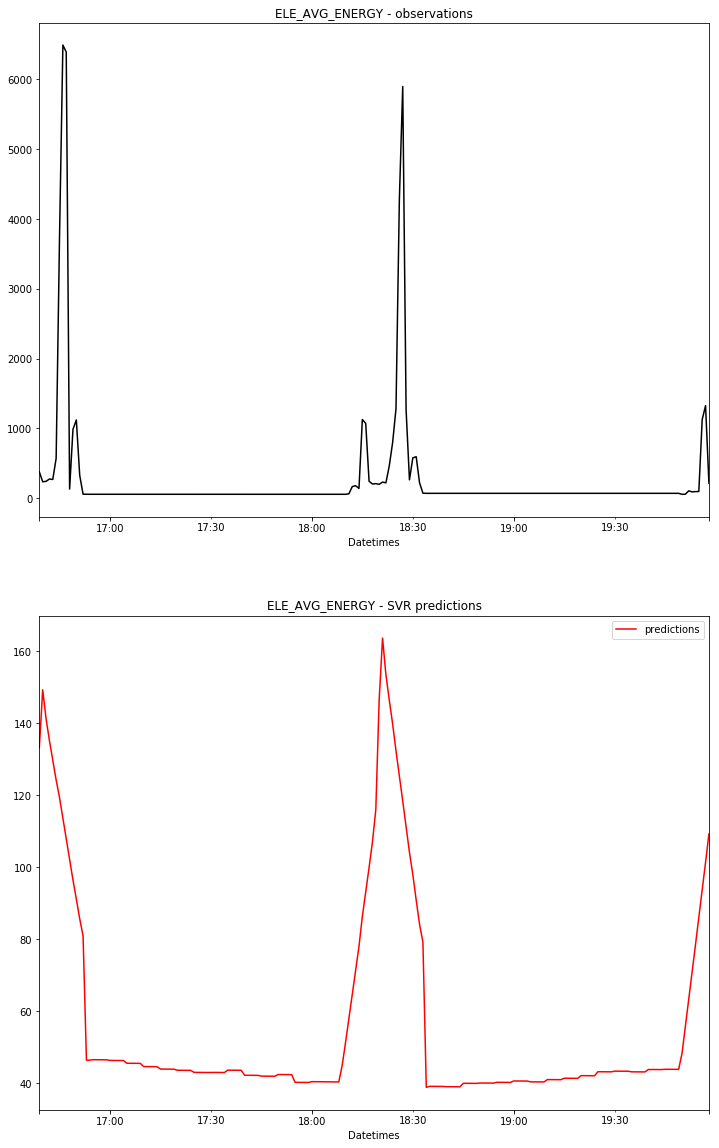

In [45]:
plot_idxs = [1000,1200]
df_pred_test = pd.DataFrame(pred_test,columns=['predictions'],index=indices_test)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12,20))
y_test.iloc[plot_idxs[0]:plot_idxs[1]].plot(ax=axes[0],c='k');
axes[0].set_title('ELE_AVG_ENERGY - observations');


df_pred_test.iloc[plot_idxs[0]:plot_idxs[1]].plot(ax=axes[1],c='r');
axes[1].set_title('ELE_AVG_ENERGY - SVR predictions');
